In [10]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

# machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor

# custom
from reflectance import plotting, file_ops, optimisation_pipeline, spectrum_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TO DO
- pipeline
- full parameter sweep
- other models? NN?
- feature importance visualisation
- Does CCA disappear on grouping?

In [19]:
# load features (spectra)
raw_spectra = spectrum_utils.load_spectra()
validation_spectra = spectrum_utils.preprocess_prism_spectra(raw_spectra, spectrum_utils.NIR_WAVELENGTHS, spectrum_utils.SENSOR_RANGE)

In [4]:
# load labels (recorded benthic cover)
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
validation_data.head()

,X,Y,Campaign,Locale,Station,TimeUTC,TimeLocal,Depth,Metabolism,Optics,...,othInvert,othOther,othSponge,othUrchin,sedLimest,sedMud,sedRubble,sedSand,ROInumber,Flightline
0,145.463908,-14.69196,GBR,Lizard Island,523,9/4/16 0:38,9/4/16 10:38,1.6,NaN,NaN,...,0,0,0,0,0,0,0,27,1,prm20160908t225710_corr_v1w2_img
1,145.463908,-14.69196,GBR,Lizard Island,523,9/4/16 0:38,9/4/16 10:38,1.6,NaN,NaN,...,0,0,0,0,0,0,0,27,1,prm20160908t225710_corr_v1w2_img
2,145.463908,-14.69196,GBR,Lizard Island,523,9/4/16 0:38,9/4/16 10:38,1.6,NaN,NaN,...,0,0,0,0,0,0,0,27,1,prm20160908t225710_corr_v1w2_img
3,145.463908,-14.69196,GBR,Lizard Island,523,9/4/16 0:38,9/4/16 10:38,1.6,NaN,NaN,...,0,0,0,0,0,0,0,27,1,prm20160908t225710_corr_v1w2_img
4,145.463908,-14.69196,GBR,Lizard Island,523,9/4/16 0:38,9/4/16 10:38,1.6,NaN,NaN,...,0,0,0,0,0,0,0,27,1,prm20160908t225710_corr_v1w2_img


In [239]:
# map between in-situ validation data and endmember categories
endmember_map = {
    'algae_crustose_coralline': ['algCCA'],
    'algae_fleshy_brown': ['algMacBrn'],
    'algae_fleshy_green': ['algMacGrn', 'algMacMix', 'algMacUnk', 'algCyano'],
    'algae_fleshy_red': ['algMacRed'],
    'algae_turf': ['algTurf'],
    'coral_blue': [],
    'coral_brown': ['crlCoral'],
    'mud': ['sedMud'],
    'octocoral': ['othOcto'],
    'sand': ['sedSand', 'crlBleach', 'sedLimest', 'sedRubble'],
    'seagrass': ['othSeagr'],
    # 'other': ['othClam', 'othInvert', 'othOther', 'othSponge', 'othUrchin']  # ignoring as max count is 3, and they don't fit categories well
}

# create empty dataframe with correct rows and column headers
validation_data_mapped = pd.DataFrame(index=validation_data.index, columns=endmember_map)

for endmember_dimensionality_reduction, validation_fields in endmember_map.items():
    # fill in validation data with sum of all fields in the category
    validation_data_mapped.loc[:, endmember_dimensionality_reduction] = validation_data.loc[:, validation_fields].sum(axis=1) 
validation_data_mapped.head()

,algae_crustose_coralline,algae_fleshy_brown,algae_fleshy_green,algae_fleshy_red,algae_turf,coral_blue,coral_brown,mud,octocoral,sand,seagrass
0,3,0,3,4,62,0.0,1,0,0,27,0
1,3,0,3,4,62,0.0,1,0,0,27,0
2,3,0,3,4,62,0.0,1,0,0,27,0
3,3,0,3,4,62,0.0,1,0,0,27,0
4,3,0,3,4,62,0.0,1,0,0,27,0


In [249]:
g_cfg, _ = file_ops.instantiate_single_configs_instance(run_ind = 0)
endmember_schema = "three_endmember"
endmember_schema_map = g_cfg.endmember_schema[endmember_schema]

grouped_val_data = pd.DataFrame()
# group validation data by endmember categories in endmember_schema_map
for endmember_dimensionality_reduction, validation_fields in endmember_schema_map.items():
    # fill in validation data with sum of all fields in the category
    grouped_val_data[endmember_dimensionality_reduction] = validation_data_mapped[validation_fields].sum(axis=1) 
grouped_val_data.head()


,algae,coral,sand
0,72,1.0,27
1,72,1.0,27
2,72,1.0,27
3,72,1.0,27
4,72,1.0,27


In [250]:
grouped_val_data

,algae,coral,sand
0,72,1.0,27
1,72,1.0,27
2,72,1.0,27
3,72,1.0,27
4,72,1.0,27
...,...,...,...
1933,59,36.0,3
1934,59,36.0,3
1935,50,48.0,1
1936,50,48.0,1


<Axes: >

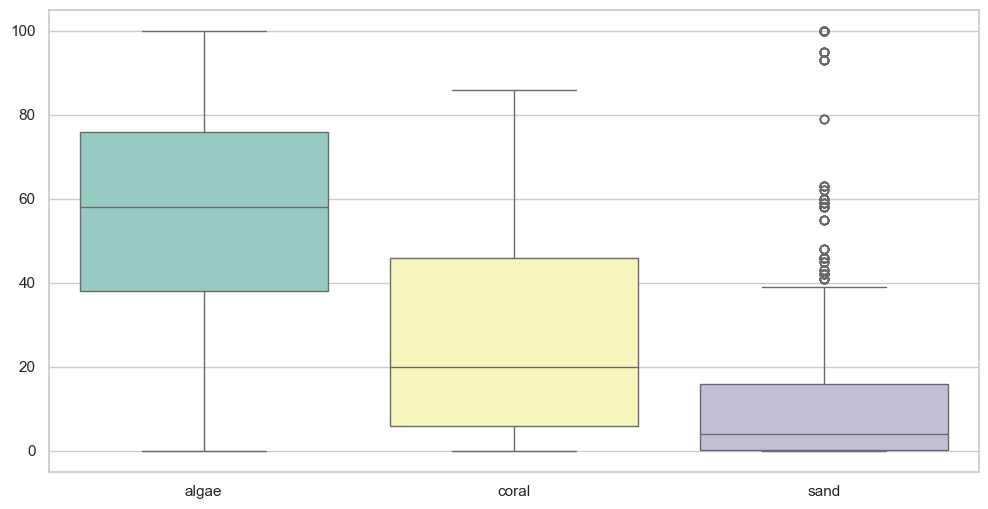

In [265]:
# plot boxplot of validation data
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.boxplot(data=grouped_val_data, palette="Set3")


In [251]:
# 80-20 train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(validation_spectra, grouped_val_data, test_size=0.2, random_state=42)

print("N train samples:", X_train.shape[0])
print("N features:", X_train.shape[1])
print("N test samples:", X_test.shape[0])
print("Label dimensions:", y_train.shape[1])

N train samples: 1550
N features: 84
N test samples: 388
Label dimensions: 3


In [257]:
# min-max normalisation
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [258]:
max_depth_values = [10, 20, 30]
n_estimators_values = [50, 100, 150]

# best_r2_multirf = -np.inf
# best_r2_rf = -np.inf
# best_params_multirf = None
# best_params_rf = None

# for max_depth in tqdm(max_depth_values, total=len(max_depth_values)):
#     for n_estimators in n_estimators_values:
#         # MultiOutputRegressor
#         regr_multirf = MultiOutputRegressor(
#             RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
#         )
#         regr_multirf.fit(X_train_scaled, y_train_scaled)
#         y_multirf = regr_multirf.predict(X_test_scaled)
#         r2_multirf = r2_score(y_test, y_multirf)
        
#         if r2_multirf > best_r2_multirf:
#             best_r2_multirf = r2_multirf
#             best_params_multirf = (max_depth, n_estimators)
        
#         # RandomForestRegressor
#         regr_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=2)
#         regr_rf.fit(X_train_scaled, y_train_scaled)
#         y_rf = regr_rf.predict(X_test_scaled)
#         r2_rf = r2_score(y_test, y_rf)
        
#         if r2_rf > best_r2_rf:
#             best_r2_rf = r2_rf
#             best_params_rf = (max_depth, n_estimators)

# print(f"Best R^2 for MultiOutputRandomForest: {best_r2_multirf} with params {best_params_multirf}")
# print(f"Best R^2 for RandomForest: {best_r2_rf} with params {best_params_rf}")

# Use the best parameters to fit the final models
max_depth, n_estimators = best_params_multirf
regr_multirf = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
)
regr_multirf.fit(X_train_scaled, y_train_scaled)

max_depth, n_estimators = best_params_rf
regr_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=2)
regr_rf.fit(X_train_scaled, y_train_scaled)

# Predict on new data
y_multirf = regr_multirf.predict(X_test_scaled)
y_rf = regr_rf.predict(X_test_scaled)

In [260]:
# calculate R^2
from sklearn.metrics import r2_score

r2_multirf = r2_score(y_test_scaled, y_multirf)
r2_rf = r2_score(y_test_scaled, y_rf)

print(f"R^2 for MultiOutputRandomForest: {r2_multirf}")
print(f"R^2 for RandomForest: {r2_rf}")

R^2 for MultiOutputRandomForest: 0.7670673683425037
R^2 for RandomForest: 0.7704227525416232


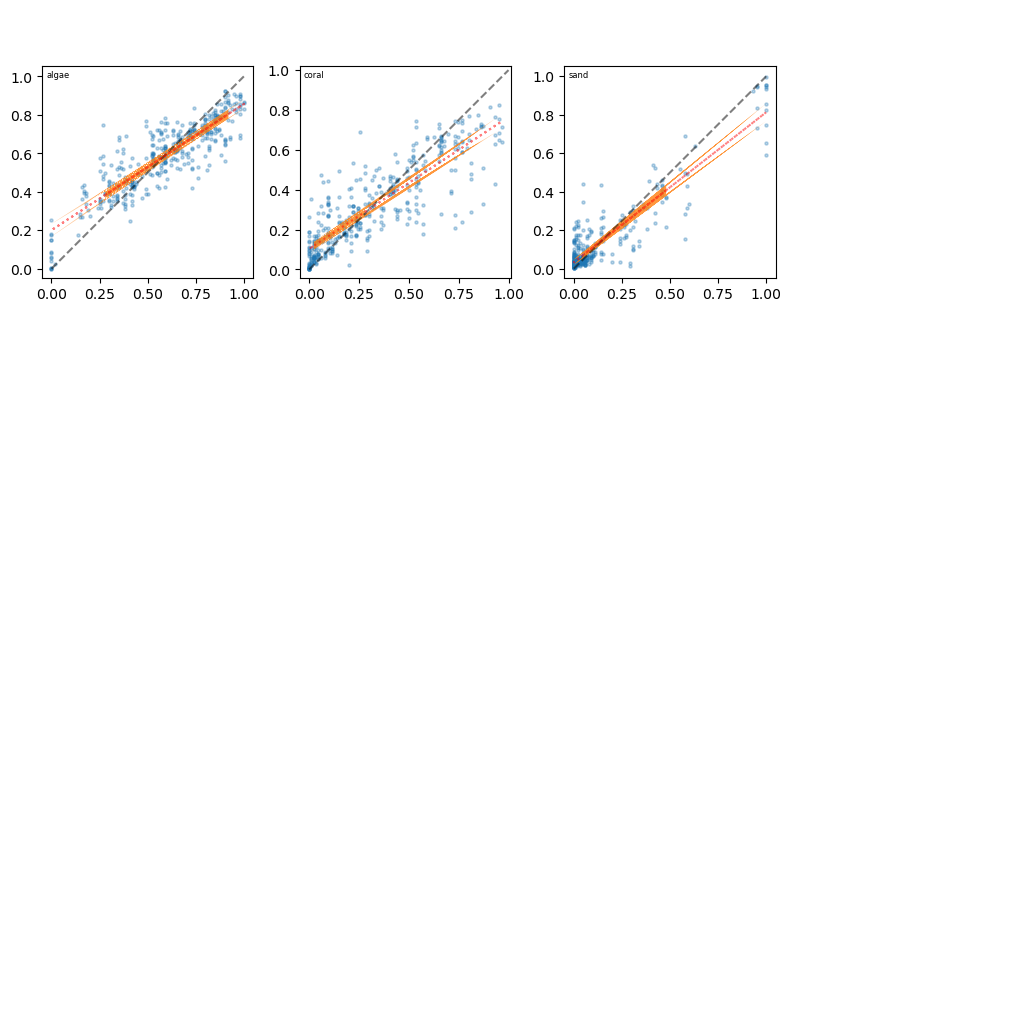

In [263]:
fig, axs = plt.subplots(3, 4, figsize=[10, 10], constrained_layout=True)

test_data = y_test_scaled
pred_data = y_rf


for i, (endmember, ax) in enumerate(zip(grouped_val_data.columns, axs.flat)):
    pred = pred_data[:,i]
    # true = test_data.astype(float).iloc[:,i]
    true = test_data[:,i]
    ax.scatter(true, pred, s=5, alpha=0.3)
    ax.text(0.02, 0.98, endmember, ha='left', va='top', transform=ax.transAxes, fontsize=6)
    ax.axis('square')
    if np.sum(pred > 0.001):
        ax.plot([0,1], [0,1], color='k', ls='--', alpha=0.5)
        try:
            p = np.polyfit(true, pred, 1)
            y_est = np.polyval(p, true)
            y_err = true.std() * np.sqrt(1/len(true) +
                          (true - true.mean())**2 / np.sum((true - true.mean())**2))
            
            r2 = r2_score(true, pred)
            ax.plot(true, y_est, color='r', ls=':', alpha=0.5, label="best fit: y = {:.2f}x + {:.2f}".format(*p))
            ax.fill_between(true, y_est - y_err, y_est + y_err, alpha=0.8)
        except np.linalg.LinAlgError:
            pass
    
    
# remove any unused axes
for ax in axs.flat[i+1:]:
    ax.axis('off')

In [276]:
validation_spectra.columns.astype(float)

Index([452.6427748, 455.4750562, 458.3073937, 461.1397875, 463.9722376,
       466.8047438, 469.6373064, 472.4699251, 475.3026001, 478.1353314,
       480.9681188, 483.8009626, 486.6338625, 489.4668187, 492.2998312,
       495.1328998, 497.9660248, 500.7992059, 503.6324433,  506.465737,
       509.2990868,  512.132493, 514.9659553, 517.7994739, 520.6330488,
       523.4666798, 526.3003672, 529.1341107, 531.9679105, 534.8017666,
       537.6356788, 540.4696474, 543.3036721, 546.1377531, 548.9718904,
       551.8060838, 554.6403336, 557.4746395, 560.3090017, 563.1434202,
       565.9778948, 568.8124258, 571.6470129, 574.4816563,  577.316356,
       580.1511118,  582.985924, 585.8207923, 588.6557169, 591.4906978,
       594.3257348, 597.1608282, 599.9959777, 602.8311835, 605.6664456,
       608.5017638, 611.3371384, 614.1725691, 617.0080561, 619.8435994,
       622.6791988, 625.5148546, 628.3505665, 631.1863347, 634.0221592,
       636.8580398, 639.6939768, 642.5299699, 645.3660193,  648.

In [302]:
importance_df.index

Index([452.6427748, 455.4750562, 458.3073937, 461.1397875, 463.9722376,
       466.8047438, 469.6373064, 472.4699251, 475.3026001, 478.1353314,
       480.9681188, 483.8009626, 486.6338625, 489.4668187, 492.2998312,
       495.1328998, 497.9660248, 500.7992059, 503.6324433,  506.465737,
       509.2990868,  512.132493, 514.9659553, 517.7994739, 520.6330488,
       523.4666798, 526.3003672, 529.1341107, 531.9679105, 534.8017666,
       537.6356788, 540.4696474, 543.3036721, 546.1377531, 548.9718904,
       551.8060838, 554.6403336, 557.4746395, 560.3090017, 563.1434202,
       565.9778948, 568.8124258, 571.6470129, 574.4816563,  577.316356,
       580.1511118,  582.985924, 585.8207923, 588.6557169, 591.4906978,
       594.3257348, 597.1608282, 599.9959777, 602.8311835, 605.6664456,
       608.5017638, 611.3371384, 614.1725691, 617.0080561, 619.8435994,
       622.6791988, 625.5148546, 628.3505665, 631.1863347, 634.0221592,
       636.8580398, 639.6939768, 642.5299699, 645.3660193,  648.

<Axes: >

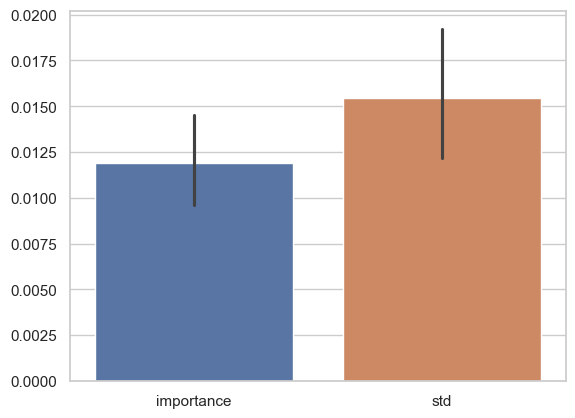

In [305]:
sns.barplot(importance_df)
# add std as error bars
# plt.errorbar(importance_df.index.astype(float), importance_df['importance'], yerr=importance_df['std'], fmt='none', capsize=5)

In [296]:
importance_df = pd.DataFrame(np.array([regr_rf.feature_importances_, np.std([tree.feature_importances_ for tree in regr_rf.estimators_], axis=0)]).T, index=validation_spectra.columns.astype(float), columns=["importance", "std"])

# plot feature importances and std as shaded region
sns.barplot(data=importance_df, x=importance_df.index, y="importance", yerr=importance_df["std"], ax=axs[-1, -1])

ValueError: 'yerr' (shape: (84,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (1,))

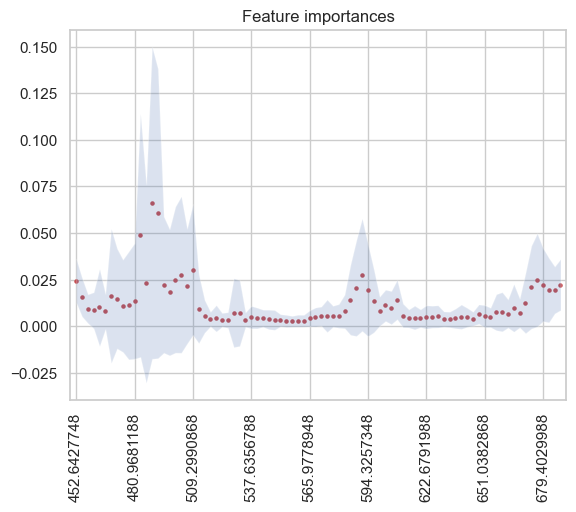

In [282]:
# feature importance
importances = regr_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr_rf.estimators_], axis=0)
# indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.scatter(range(X_train.shape[1]), importances, color="r", s=5)
# plot uncertainty as shaded region
plt.fill_between(range(X_train.shape[1]), importances - std, importances + std, alpha=0.2)

# replace xticks with wavelength values
wvs = validation_spectra.columns.astype(float)
plt.xticks(range(X_train.shape[1])[::10], wvs[::10], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()